Things remaining to do:  
- Implement time it to see how long it takes to train each model 
- Add regularization parameter
- save model somewhere else

# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

Evaluated the following parameters:  
1. SS vs MS architecture
2. 

Things remaining to do: 
- log training and validation scores for each model at each epoch (use 100)
- plot learning curves

---
# Admin

Load packages and set notebook parameters

In [1]:
import numpy as np
import pandas as pd
import cv2

import os

import tensorflow as tf

In [2]:
from tensorflow.contrib.layers import flatten

In [3]:
from sklearn.utils import shuffle

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (16.0, 6.0)

---
# Load data

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [5]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

inputs_loc = '/media/fqaiser94/ff3daf1f-fc36-43a4-a218-478126941f2a/traffic-signs-data/'

training_file = inputs_loc + 'train.p'
validation_file= inputs_loc + 'valid.p'
testing_file = inputs_loc + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [6]:
X_train, y_train = shuffle(X_train, y_train)

In [7]:
signnames = pd.read_csv(filepath_or_buffer='/home/fqaiser94/CarND-Traffic-Sign-Classifier-Project/signnames.csv')

In [8]:
signnames.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [9]:
signnames.index.get_loc(0)

0

In [10]:
signnames.at[signnames[signnames.ClassId==0].index[0],'SignName']

'Speed limit (20km/h)'

---
# EDA

Results of basic exploratory data analysis.  

Imbalanced classes

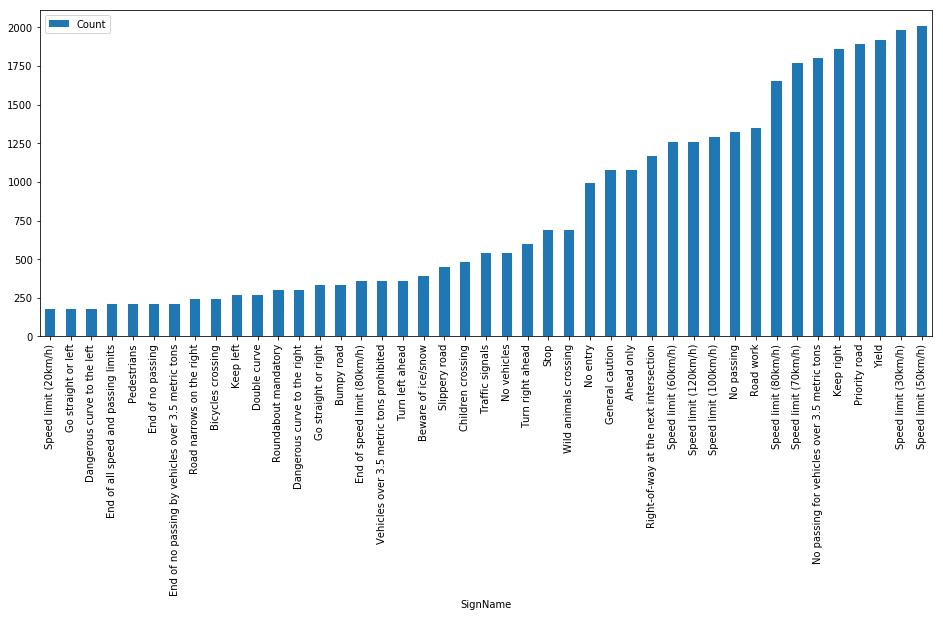

In [11]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)

df = pd.DataFrame({'ClassId':unique_elements, 
                   'Count':counts_elements
                  })

df = pd.merge(df, signnames, on=['ClassId'])

df = df.sort_values('Count')

df.plot('SignName', 'Count', kind='bar')

Sample class images

Class 0: Speed limit (20km/h)  180 samples


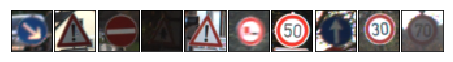

--------------------------------------------------------------------------------------

Class 1: Speed limit (30km/h)  1980 samples


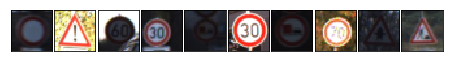

--------------------------------------------------------------------------------------

Class 2: Speed limit (50km/h)  2010 samples


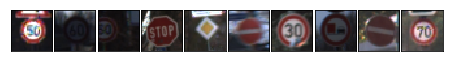

--------------------------------------------------------------------------------------

Class 3: Speed limit (60km/h)  1260 samples


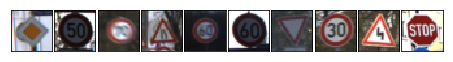

--------------------------------------------------------------------------------------

Class 4: Speed limit (70km/h)  1770 samples


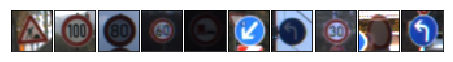

--------------------------------------------------------------------------------------

Class 5: Speed limit (80km/h)  1650 samples


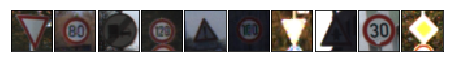

--------------------------------------------------------------------------------------

Class 6: End of speed limit (80km/h)  360 samples


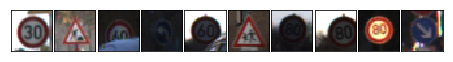

--------------------------------------------------------------------------------------

Class 7: Speed limit (100km/h)  1290 samples


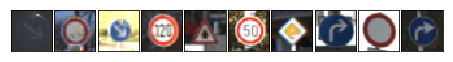

--------------------------------------------------------------------------------------

Class 8: Speed limit (120km/h)  1260 samples


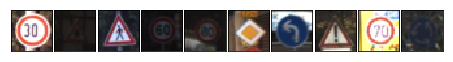

--------------------------------------------------------------------------------------

Class 9: No passing  1320 samples


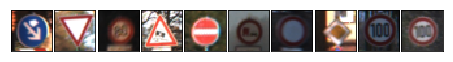

--------------------------------------------------------------------------------------

Class 10: No passing for vehicles over 3.5 metric tons  1800 samples


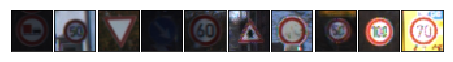

--------------------------------------------------------------------------------------

Class 11: Right-of-way at the next intersection  1170 samples


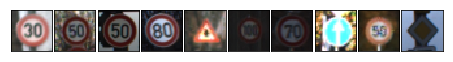

--------------------------------------------------------------------------------------

Class 12: Priority road  1890 samples


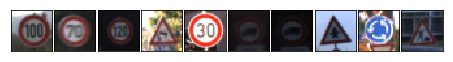

--------------------------------------------------------------------------------------

Class 13: Yield     1920 samples


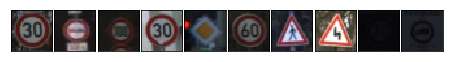

--------------------------------------------------------------------------------------

Class 14: Stop      690 samples


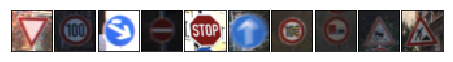

--------------------------------------------------------------------------------------

Class 15: No vehicles  540 samples


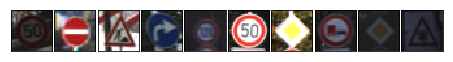

--------------------------------------------------------------------------------------

Class 16: Vehicles over 3.5 metric tons prohibited  360 samples


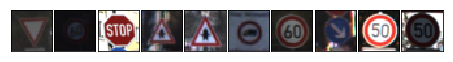

--------------------------------------------------------------------------------------

Class 17: No entry  990 samples


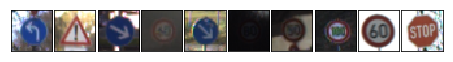

--------------------------------------------------------------------------------------

Class 18: General caution  1080 samples


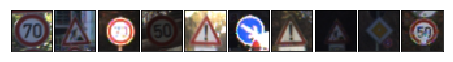

--------------------------------------------------------------------------------------

Class 19: Dangerous curve to the left  180 samples


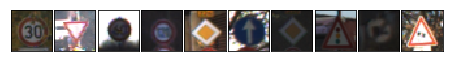

--------------------------------------------------------------------------------------

Class 20: Dangerous curve to the right  300 samples


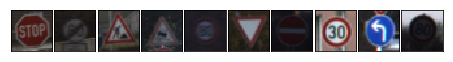

--------------------------------------------------------------------------------------

Class 21: Double curve  270 samples


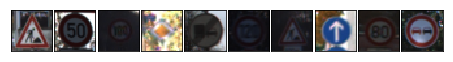

--------------------------------------------------------------------------------------

Class 22: Bumpy road  330 samples


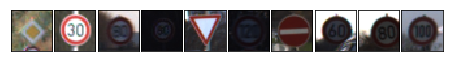

--------------------------------------------------------------------------------------

Class 23: Slippery road  450 samples


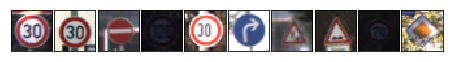

--------------------------------------------------------------------------------------

Class 24: Road narrows on the right  240 samples


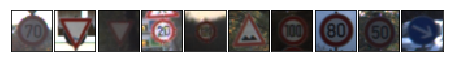

--------------------------------------------------------------------------------------

Class 25: Road work  1350 samples


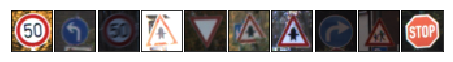

--------------------------------------------------------------------------------------

Class 26: Traffic signals  540 samples


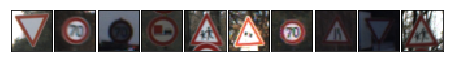

--------------------------------------------------------------------------------------

Class 27: Pedestrians  210 samples


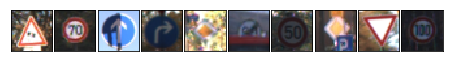

--------------------------------------------------------------------------------------

Class 28: Children crossing  480 samples


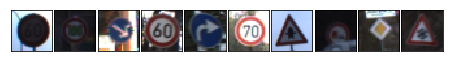

--------------------------------------------------------------------------------------

Class 29: Bicycles crossing  240 samples


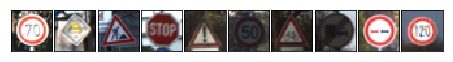

--------------------------------------------------------------------------------------

Class 30: Beware of ice/snow  390 samples


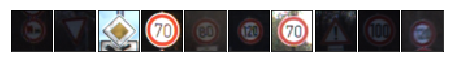

--------------------------------------------------------------------------------------

Class 31: Wild animals crossing  690 samples


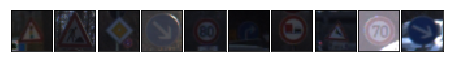

--------------------------------------------------------------------------------------

Class 32: End of all speed and passing limits  210 samples


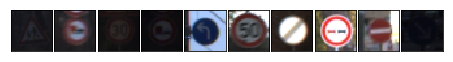

--------------------------------------------------------------------------------------

Class 33: Turn right ahead  599 samples


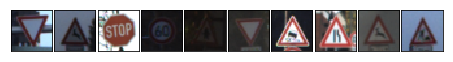

--------------------------------------------------------------------------------------

Class 34: Turn left ahead  360 samples


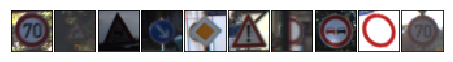

--------------------------------------------------------------------------------------

Class 35: Ahead only  1080 samples


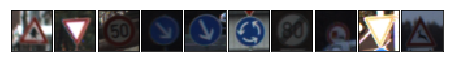

--------------------------------------------------------------------------------------

Class 36: Go straight or right  330 samples


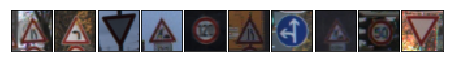

--------------------------------------------------------------------------------------

Class 37: Go straight or left  180 samples


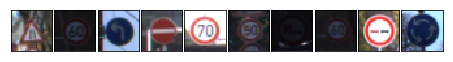

--------------------------------------------------------------------------------------

Class 38: Keep right  1860 samples


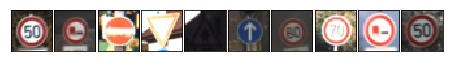

--------------------------------------------------------------------------------------

Class 39: Keep left  270 samples


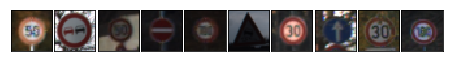

--------------------------------------------------------------------------------------

Class 40: Roundabout mandatory  300 samples


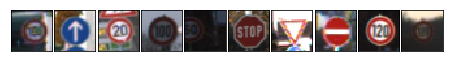

--------------------------------------------------------------------------------------

Class 41: End of no passing  210 samples


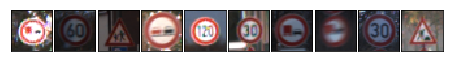

--------------------------------------------------------------------------------------

Class 42: End of no passing by vehicles over 3.5 metric tons  210 samples


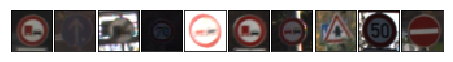

--------------------------------------------------------------------------------------



In [12]:
import random

col_width = max(len(name) for name in signnames)

sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)

for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    #print("Class %i: %s  %s samples" % (c, col_width, str(c_count)))
    print("Class %i: %-*s  %s samples" % (c, 
                                          col_width, 
                                          signnames.at[signnames[signnames.ClassId==c].index[0],'SignName'], 
                                          str(c_count)
                                         ))
    fig = plt.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_indices[i]])
    plt.show()
    print("--------------------------------------------------------------------------------------\n")

---
# Define functions

Define some useful function.  

In [13]:
def random_image(array, index=None): 
    
    if index==None: 
        
        max_index = len(array)
        index = np.random.randint(low=0,high=max_index)
    
    img = array[index].squeeze()
    
    plt.imshow(img)

In [14]:
def calc_filter_length(old_length, new_length, padding, stride): 

    # OG formula
    # new_width = (old_width - filter_width + 2*padding)/stride + 1
    # rewrite to solve for filter_width
    filter_length = -1*(stride*(new_length-1) - 2*padding - old_length)    
    
    return filter_length

In [15]:
# test function 

filter_length = calc_filter_length(old_length = 32, 
                                  new_length = 28, 
                                  padding = 0, 
                                  stride = 1
                                 )
assert filter_length==5, "Houston we've got a problem"

----
# Model 1: LeNet

Build a baseline model based on the original LeNet architecture.  

![LeNet Architecture](http://eblearn.sourceforge.net/lib/exe/lenet5.png)
Source: Yan LeCun

## Step 1: Prep Data

In [16]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed. 

def normalize(data):
    
    data_normalized = (data - 128) / 128
    
    return data_normalized

In [17]:
def rgb2gray(rgb):
    
    x = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
    #x = np.reshape(x, x.shape + (1,))
    
    x = x.reshape(x.shape + (1,)) 

        
    return x 

In [18]:
X_train.shape

(34799, 32, 32, 3)

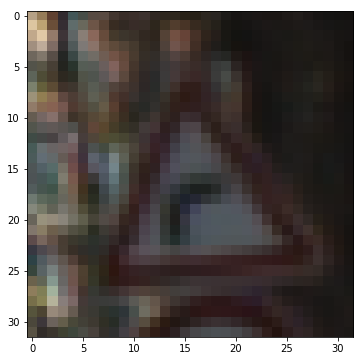

In [19]:
random_image(array=X_train, index=1000)

In [20]:
print('old mean: %s' %np.mean(X_train))
print('old std:  %s' %np.std(X_train))

old mean: 82.677589037
old std:  67.8508884263


In [21]:
def preprocess(x): 
    
    x = normalize(x)
    x = rgb2gray(x)
    
    return x

In [22]:
X_train_processed = preprocess(X_train)
X_valid_processed = preprocess(X_valid)
X_test_processed  = preprocess(X_test)

In [23]:
X_train_processed.shape

(34799, 32, 32, 1)

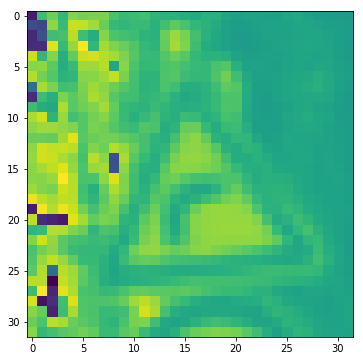

In [24]:
random_image(array=X_train_processed, index=1000)

In [25]:
print('new mean: %s' %np.mean(X_train_processed))
print('new std:  %s' %np.std(X_train_processed))

new mean: 1.22069521794
new std:  0.392135235831


## Step 2: Design and Test a Model Architecture

define training pipeline/architecture. 

In [26]:
def cnn(x):
    
    # vanilla LeNet implementation
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Step 3: Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [27]:
EPOCHS = 10
BATCH_SIZE = 128

In [28]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [29]:
rate = 0.001

logits = cnn(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [30]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver(max_to_keep=None)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [31]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_processed)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_processed[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid_processed, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
        
    #saver.save(sess, './lenet')
    #print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.278

EPOCH 2 ...
Validation Accuracy = 0.469

EPOCH 3 ...
Validation Accuracy = 0.586

EPOCH 4 ...
Validation Accuracy = 0.659

EPOCH 5 ...
Validation Accuracy = 0.698

EPOCH 6 ...
Validation Accuracy = 0.716

EPOCH 7 ...
Validation Accuracy = 0.728

EPOCH 8 ...
Validation Accuracy = 0.741

EPOCH 9 ...
Validation Accuracy = 0.750

EPOCH 10 ...
Validation Accuracy = 0.754



76% accuracy with the vanilla LeNet implementation. Pretty terrible but not as bad as perhaps we might have expected. Let's see if we can improve on that in our next model.  

----
# Model 2

Attempt to build architecture similar to [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).  

We will use only the y channel, (research papers show color doesn't typically help).  
We'll also trying using a multi stage (MS) architecture.  

## Step 1: Prep Data

In [32]:
def rgb2y(array):
    
    array_y = np.empty((len(array), 32, 32, 1))
    
    for i in range(len(array)):
    
        img_yuv = cv2.cvtColor(np.array(array[i], dtype=np.uint8), cv2.COLOR_BGR2YUV, 1)
        y, u, v = cv2.split(img_yuv)
        
        y_reshaped = np.reshape(y, y.shape + (1,))

        array_y[i] = y_reshaped
        
    return array_y

In [33]:
def global_contrast_normalization(array, s=1, lmda=10, epsilon=0.000000001):    
    
    # https://datascience.stackexchange.com/questions/15110/how-to-implement-global-contrast-normalization-in-python

    array_y = np.empty((len(array), 32, 32, 1))
    
    for i in range(len(array)):
    
        X_average = np.mean(array[i])
    
        X = array[i] - X_average

        contrast = np.sqrt(lmda + np.mean(X**2))

        X = s * X / max(contrast, epsilon)

        array_y[i] = X
        
    return array_y

In [34]:
X_train.shape

(34799, 32, 32, 3)

In [35]:
print('old mean: %s' %np.mean(X_train))
print('old std:  %s' %np.std(X_train))

old mean: 82.677589037
old std:  67.8508884263


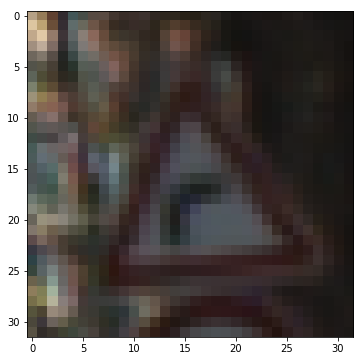

In [36]:
random_image(array=X_train, index=1000)

In [37]:
def preprocess(x): 
    
    x = rgb2y(x)
    x = global_contrast_normalization(x)
    
    return x

In [38]:
X_train_processed = preprocess(X_train)
X_valid_processed = preprocess(X_valid)
X_test_processed  = preprocess(X_test)

In [39]:
X_train_processed.shape

(34799, 32, 32, 1)

In [40]:
print('new mean: %s' %np.mean(X_train_processed))
print('new std:  %s' %np.std(X_train_processed))

new mean: -5.56946982251e-20
new std:  0.984310348751


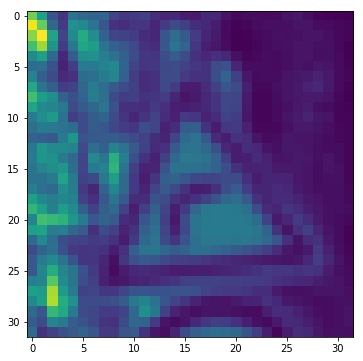

In [41]:
random_image(array=X_train_processed, index=1000)

## Step 2: Design and Test a Model Architecture

define training pipeline/architecture. 

In [42]:
def cnn(x):
    
    # Modelled after
    # "Traffic Sign Recognition with Multi-Scale Convolutional Networks"
    # By Pierre Sermanet and Yann LeCun
    
    
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x108.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 108), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(108))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    act1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x108. Output = 14x14x108.
    pool1 = tf.nn.max_pool(act1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # SOLUTION: Dropout
    #drop1 = tf.nn.dropout(pool1, 0.5)

    
    
    # SOLUTION: Layer 2: Convolutional. Input = 14x14x108. Output = 10x10x200.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 108, 200), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(200))
    conv2   = tf.nn.conv2d(pool1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    act2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x200. Output = 5x5x200.
    pool2 = tf.nn.max_pool(act2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # SOLUTION: Dropout
    #drop2 = tf.nn.dropout(pool2, 0.5)

    
    
    # SOLUTION: Flatten. Input = 5x5x108. Output = 5000.
    
    # 1st stage output
    shape = pool1.get_shape().as_list()
    pool1 = tf.reshape(pool1, [-1, shape[1] * shape[2] * shape[3]])
    
    # 2nd stage output
    shape = pool2.get_shape().as_list()
    pool2 = tf.reshape(pool2, [-1, shape[1] * shape[2] * shape[3]])    
    
    fc0  = tf.concat(axis=1, values=[pool1, pool2])
    #fc0 = tf.concat(1, [pool1, pool2])
    #fc0 = flatten(drop2)
    
    
    
    # SOLUTION: Layer 3: Fully Connected. Input = 26168. Output = 100.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(26168, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # SOLUTION: Dropout
    #fc1 = tf.nn.dropout(fc1, 0.5)

    
    

    # SOLUTION: Layer 4: Fully Connected. Input = 100. Output = 50.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 100), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(100))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
        
    # SOLUTION: Dropout
    #fc2 = tf.nn.dropout(fc2, 0.5)

    
    
    # SOLUTION: Layer 5: Fully Connected. Input = 50. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(100, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [43]:
EPOCHS = 10
BATCH_SIZE = 128

In [44]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [45]:
rate = 0.001

logits = cnn(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [46]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver(max_to_keep=None)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [47]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_processed)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_processed[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid_processed, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    #saver.save(sess, './lenet')
    #print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.871

EPOCH 2 ...
Validation Accuracy = 0.896

EPOCH 3 ...
Validation Accuracy = 0.895

EPOCH 4 ...
Validation Accuracy = 0.914

EPOCH 5 ...
Validation Accuracy = 0.920

EPOCH 6 ...
Validation Accuracy = 0.915

EPOCH 7 ...
Validation Accuracy = 0.922

EPOCH 8 ...
Validation Accuracy = 0.912

EPOCH 9 ...
Validation Accuracy = 0.918

EPOCH 10 ...
Validation Accuracy = 0.916



93% accuracy, that's a big jump from Model 1.  
Human level performance is about 98%. Let's see if we can get closer still.  

----
# Model 3

Attempt to build architecture similar to [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).  

We'll add some dropouts to our model.    

## Step 1: Prep Data

In [48]:
def rgb2y(array):
    
    array_y = np.empty((len(array), 32, 32, 1))
    
    for i in range(len(array)):
    
        img_yuv = cv2.cvtColor(np.array(array[i], dtype=np.uint8), cv2.COLOR_BGR2YUV, 1)
        y, u, v = cv2.split(img_yuv)
        
        y_reshaped = np.reshape(y, y.shape + (1,))

        array_y[i] = y_reshaped
        
    return array_y

In [49]:
def global_contrast_normalization(array, s=1, lmda=10, epsilon=0.000000001):    
    
    # https://datascience.stackexchange.com/questions/15110/how-to-implement-global-contrast-normalization-in-python

    array_y = np.empty((len(array), 32, 32, 1))
    
    for i in range(len(array)):
    
        X_average = np.mean(array[i])
    
        X = array[i] - X_average

        contrast = np.sqrt(lmda + np.mean(X**2))

        X = s * X / max(contrast, epsilon)

        array_y[i] = X
        
    return array_y

In [50]:
X_train.shape

(34799, 32, 32, 3)

In [51]:
print('old mean: %s' %np.mean(X_train))
print('old std:  %s' %np.std(X_train))

old mean: 82.677589037
old std:  67.8508884263


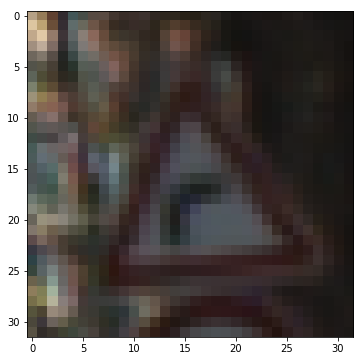

In [52]:
random_image(array=X_train, index=1000)

In [53]:
def preprocess(x): 
    
    x = rgb2y(x)
    x = global_contrast_normalization(x)
    
    return x

In [54]:
X_train_processed = preprocess(X_train)
X_valid_processed = preprocess(X_valid)
X_test_processed  = preprocess(X_test)

In [55]:
X_train_processed.shape

(34799, 32, 32, 1)

In [56]:
print('new mean: %s' %np.mean(X_train_processed))
print('new std:  %s' %np.std(X_train_processed))

new mean: -5.56946982251e-20
new std:  0.984310348751


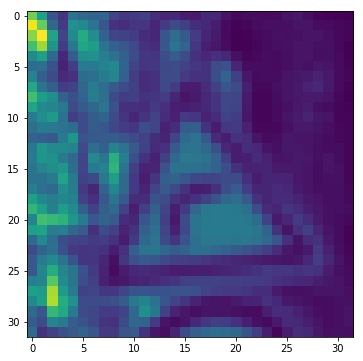

In [57]:
random_image(array=X_train_processed, index=1000)

## Step 2: Design and Test a Model Architecture

define training pipeline/architecture. 

In [58]:
from collections import namedtuple

Parameters = namedtuple(
    'Parameters', 
    [
        # Data parameters
        'num_classes', 
        'image_size', 
        
        # Layers architecture
        'conv1_k', 
        'conv1_d', 
        'conv1_p',
        
        'conv2_k', 
        'conv2_d', 
        'conv2_p', 
        
        #'conv3_k', 
        #'conv3_d', 
        #'conv3_p', 
        
        'fc1_size', 
        'fc1_p'
    ])

In [59]:
parameters = Parameters(
    # Data parameters
    num_classes = 43,
    image_size = (32, 32),
    
    # Layers architecture
    conv1_k = 5, 
    conv1_d = 32,
    conv1_p = 0.9,
    
    conv2_k = 5, 
    conv2_d = 64, 
    conv2_p = 0.8,
    
    #conv3_k = 5, 
    #conv3_d = 128, 
    #conv3_p = 0.7,
    
    fc1_size = 1000, 
    fc1_p = 0.5
)

In [60]:
def cnn(x, params, is_training=False):
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x32.
    conv1_W = tf.Variable(
        tf.truncated_normal(
            shape=(params.conv1_k, params.conv1_k, 1, params.conv1_d), 
            mean = mu, 
            stddev = sigma
        )
    )
    
    conv1_b = tf.Variable(
        tf.zeros(params.conv1_d)
    )
    
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    act1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x32. Output = 14x14x32.
    pool1 = tf.nn.max_pool(act1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # SOLUTION: Dropout
    if is_training: 
        pool1 = tf.nn.dropout(pool1, params.conv1_p)

    
    
    # SOLUTION: Layer 2: Convolutional. Input = 14x14x32. Output = 10x10x64.
    conv2_W = tf.Variable(
        tf.truncated_normal(
            shape=(params.conv2_k, params.conv2_k, params.conv1_d, params.conv2_d), 
            mean = mu, 
            stddev = sigma
        )
    )
    
    conv2_b = tf.Variable(
        tf.zeros(params.conv2_d)
    )
    
    conv2 = tf.nn.conv2d(pool1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    act2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x64. Output = 5x5x64.
    pool2 = tf.nn.max_pool(act2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # SOLUTION: Dropout
    if is_training: 
        pool2 = tf.nn.dropout(pool2, params.conv2_p)
    
    
    
    # SOLUTION: Flatten.     
    # 1st stage output 14x14x32
    pool1 = tf.nn.max_pool(pool1, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='VALID')
    shape = pool1.get_shape().as_list()
    pool1 = tf.reshape(pool1, [-1, shape[1] * shape[2] * shape[3]])
    
    # 2nd stage output 5x5x64
    shape = pool2.get_shape().as_list()
    pool2 = tf.reshape(pool2, [-1, shape[1] * shape[2] * shape[3]])
    
    # flatten
    fc0  = tf.concat(axis=1, values=[pool1, pool2])
    
    
    
    # SOLUTION: Layer 3: Fully Connected. Input = 1888. Output = 500.
    fc1_W = tf.Variable(
        tf.truncated_normal(
            shape=(1888, params.fc1_size), 
            mean = mu, 
            stddev = sigma
        )
    )
    
    fc1_b = tf.Variable(
        tf.zeros(params.fc1_size)
    )
    
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1 = tf.nn.relu(fc1)
    
    # SOLUTION: Dropout
    if is_training: 
        fc1 = tf.nn.dropout(fc1, 0.5)
      

    # SOLUTION: Layer 4: Fully Connected. Input = 500. Output = 43.
    fc2_W  = tf.Variable(
        tf.truncated_normal(
            shape=(params.fc1_size, params.num_classes), 
            mean = mu, 
            stddev = sigma
        )
    )
    
    fc2_b  = tf.Variable(
        tf.zeros(params.num_classes)
    )
    
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    
    return logits

In [61]:
EPOCHS = 10
BATCH_SIZE = 128

In [62]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [63]:
rate = 0.001

logits = cnn(x, params=parameters, is_training=True)
logits_no_dropout = cnn(x, params=parameters, is_training=False)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [64]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver(max_to_keep=None)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [65]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_processed)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_processed[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid_processed, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    #saver.save(sess, './lenet')
    #print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.761

EPOCH 2 ...
Validation Accuracy = 0.837

EPOCH 3 ...
Validation Accuracy = 0.877

EPOCH 4 ...
Validation Accuracy = 0.888

EPOCH 5 ...
Validation Accuracy = 0.895

EPOCH 6 ...
Validation Accuracy = 0.906

EPOCH 7 ...
Validation Accuracy = 0.908

EPOCH 8 ...
Validation Accuracy = 0.917

EPOCH 9 ...
Validation Accuracy = 0.917

EPOCH 10 ...
Validation Accuracy = 0.926



93% accuracy. Perhaps we can do better still.  

----
# Model 4

We'll try using:   
- more layers, both in the feature generation and classification stages.  
- Decayed learning rate  

Things remaining to try:  
- More preprocessing  
- Regularization

## Step 1: Prep Data

In [66]:
def rgb2y(array):
    
    array_y = np.empty((len(array), 32, 32, 1))
    
    for i in range(len(array)):
    
        img_yuv = cv2.cvtColor(np.array(array[i], dtype=np.uint8), cv2.COLOR_BGR2YUV, 1)
        y, u, v = cv2.split(img_yuv)
        
        y_reshaped = np.reshape(y, y.shape + (1,))

        array_y[i] = y_reshaped
        
    return array_y

In [67]:
def global_contrast_normalization(array, s=1, lmda=10, epsilon=0.000000001):    
    
    # https://datascience.stackexchange.com/questions/15110/how-to-implement-global-contrast-normalization-in-python

    array_y = np.empty((len(array), 32, 32, 1))
    
    for i in range(len(array)):
    
        X_average = np.mean(array[i])
    
        X = array[i] - X_average

        contrast = np.sqrt(lmda + np.mean(X**2))

        X = s * X / max(contrast, epsilon)

        array_y[i] = X
        
    return array_y

In [68]:
X_train.shape

(34799, 32, 32, 3)

In [69]:
print('old mean: %s' %np.mean(X_train))
print('old std:  %s' %np.std(X_train))

old mean: 82.677589037
old std:  67.8508884263


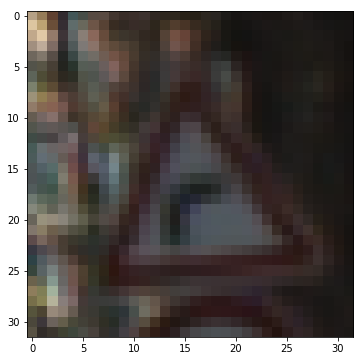

In [70]:
random_image(array=X_train, index=1000)

In [71]:
def preprocess(x): 
    
    x = rgb2y(x)
    x = global_contrast_normalization(x)
    
    return x

In [72]:
X_train_processed = preprocess(X_train)
X_valid_processed = preprocess(X_valid)
X_test_processed  = preprocess(X_test)

In [73]:
X_train_processed.shape

(34799, 32, 32, 1)

In [74]:
print('new mean: %s' %np.mean(X_train_processed))
print('new std:  %s' %np.std(X_train_processed))

new mean: -5.56946982251e-20
new std:  0.984310348751


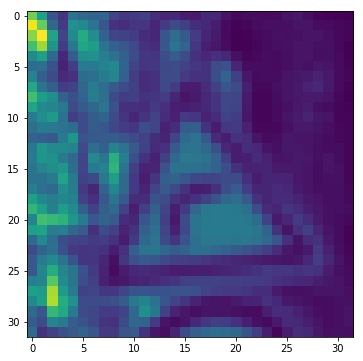

In [75]:
random_image(array=X_train_processed, index=1000)

## Step 2: Design and Test a Model Architecture

define training pipeline/architecture. 

In [76]:
from collections import namedtuple

Parameters = namedtuple(
    'Parameters', 
    [
        # Data parameters
        'num_classes', 
        'image_size', 
        
        # Layers architecture
        'conv1_k', 
        'conv1_d', 
        'conv1_p',
        
        'conv2_k', 
        'conv2_d', 
        'conv2_p', 
        
        'conv3_k', 
        'conv3_d', 
        'conv3_p', 
        
        'fc1_size', 
        'fc1_p', 
        
        'fc2_size', 
        'fc2_p'
    ])

In [77]:
parameters = Parameters(
    # Data parameters
    num_classes = 43,
    image_size = (32, 32),

    # Layers architecture
    conv1_k = 5, 
    conv1_d = 32,
    conv1_p = 0.9,
    
    conv2_k = 5, 
    conv2_d = 64, 
    conv2_p = 0.8,
    
    conv3_k = 5, 
    conv3_d = 128, 
    conv3_p = 0.7,
    
    fc1_size = 1000, 
    fc1_p = 0.5,
    
    fc2_size = 500, 
    fc2_p = 0.5
)

In [78]:
def cnn(x, params, is_training=False):
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x32.
    conv1_W = tf.Variable(
        tf.truncated_normal(
            shape=(params.conv1_k, params.conv1_k, 1, params.conv1_d), 
            mean = mu, 
            stddev = sigma
        )
    )
    
    conv1_b = tf.Variable(
        tf.zeros(params.conv1_d)
    )
    
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

    # SOLUTION: Activation.
    act1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x32. Output = 14x14x32.
    pool1 = tf.nn.max_pool(act1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # SOLUTION: Dropout
    if is_training: 
        pool1 = tf.nn.dropout(pool1, params.conv1_p)

    
    
    # SOLUTION: Layer 2: Convolutional. Input = 14x14x32. Output = 10x10x64.
    conv2_W = tf.Variable(
        tf.truncated_normal(
            shape=(params.conv2_k, params.conv2_k, params.conv1_d, params.conv2_d), 
            mean = mu, 
            stddev = sigma
        )
    )
    
    conv2_b = tf.Variable(
        tf.zeros(params.conv2_d)
    )
    
    conv2 = tf.nn.conv2d(pool1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    # SOLUTION: Activation.
    act2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x64. Output = 5x5x64.
    pool2 = tf.nn.max_pool(act2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # SOLUTION: Dropout
    if is_training: 
        pool2 = tf.nn.dropout(pool2, params.conv2_p)
    
    
    
    # SOLUTION: Layer 3: Convolutional. Input = 5x5x64. Output = 1x1x128.
    conv3_W = tf.Variable(
        tf.truncated_normal(
            shape=(params.conv3_k, params.conv3_k, params.conv2_d, params.conv3_d), 
            mean = mu, 
            stddev = sigma
        )
    )
    conv3_b = tf.Variable(
        tf.zeros(params.conv3_d)
    )
    conv3 = tf.nn.conv2d(pool2, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b
    
    # SOLUTION: Activation.
    act3 = tf.nn.relu(conv3)

    # SOLUTION: Pooling. Input = 1x1x128. Output = ??x??x128.
    pool3 = tf.nn.max_pool(act3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # SOLUTION: Dropout
    if is_training: 
        pool3 = tf.nn.dropout(pool3, params.conv3_p)

    
    
    # SOLUTION: Flatten.     
    # 1st stage output 14x14x32
    pool1 = tf.nn.max_pool(pool1, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    shape = pool1.get_shape().as_list()
    pool1 = tf.reshape(pool1, [-1, shape[1] * shape[2] * shape[3]])
    
    # 2nd stage output 5x5x64    
    pool2 = tf.nn.max_pool(pool2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    shape = pool2.get_shape().as_list()
    pool2 = tf.reshape(pool2, [-1, shape[1] * shape[2] * shape[3]])
    
    # 3rd stage output 1x1x128
    shape = pool3.get_shape().as_list()
    pool3 = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])
    
    # flatten
    fc0  = tf.concat(axis=1, values=[pool1, pool2, pool3])
    
    
    
    # SOLUTION: Layer 3: Fully Connected. Input = 1888. Output = 1000.
    fc1_W = tf.Variable(
        tf.truncated_normal(
            shape=(2816, params.fc1_size), 
            mean = mu, 
            stddev = sigma
        )
    )
    
    fc1_b = tf.Variable(
        tf.zeros(params.fc1_size)
    )
    
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1 = tf.nn.relu(fc1)
    
    # SOLUTION: Dropout
    if is_training: 
        fc1 = tf.nn.dropout(fc1, params.fc1_p)
        
        
    
    # SOLUTION: Layer 4: Fully Connected. Input = 1000. Output = 500.
    fc2_W = tf.Variable(
        tf.truncated_normal(
            shape=(params.fc1_size, params.fc2_size), 
            mean = mu, 
            stddev = sigma
        )
    )
    
    fc2_b = tf.Variable(
        tf.zeros(params.fc2_size)
    )
    
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2 = tf.nn.relu(fc2)
    
    # SOLUTION: Dropout
    if is_training: 
        fc2 = tf.nn.dropout(fc2, params.fc2_p)
        
        
    
      

    # SOLUTION: Layer 5: Fully Connected. Input = 500. Output = 43.
    fc3_W  = tf.Variable(
        tf.truncated_normal(
            shape=(params.fc2_size, params.num_classes), 
            mean = mu, 
            stddev = sigma
        )
    )
    
    fc3_b  = tf.Variable(
        tf.zeros(params.num_classes)
    )
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [79]:
EPOCHS = 30
BATCH_SIZE = 128

In [80]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [81]:
# rate = 0.001

global_step = tf.Variable(0, trainable=False)

rate = tf.train.exponential_decay(
    learning_rate = 0.001, 
    global_step = global_step,
    decay_steps = 1000, 
    decay_rate = 0.6, 
    staircase = True
)


logits = cnn(x, params=parameters, is_training=True)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [82]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver(max_to_keep=None)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [83]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_processed)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_processed[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid_processed, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    #saver.save(sess, './lenet')
    #print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.195

EPOCH 2 ...
Validation Accuracy = 0.348

EPOCH 3 ...
Validation Accuracy = 0.466

EPOCH 4 ...
Validation Accuracy = 0.546

EPOCH 5 ...
Validation Accuracy = 0.627

EPOCH 6 ...
Validation Accuracy = 0.685

EPOCH 7 ...
Validation Accuracy = 0.726

EPOCH 8 ...
Validation Accuracy = 0.764

EPOCH 9 ...
Validation Accuracy = 0.786

EPOCH 10 ...
Validation Accuracy = 0.798

EPOCH 11 ...
Validation Accuracy = 0.824

EPOCH 12 ...
Validation Accuracy = 0.839

EPOCH 13 ...
Validation Accuracy = 0.846

EPOCH 14 ...
Validation Accuracy = 0.849

EPOCH 15 ...
Validation Accuracy = 0.859

EPOCH 16 ...
Validation Accuracy = 0.867

EPOCH 17 ...
Validation Accuracy = 0.869

EPOCH 18 ...
Validation Accuracy = 0.868

EPOCH 19 ...
Validation Accuracy = 0.869

EPOCH 20 ...
Validation Accuracy = 0.887

EPOCH 21 ...
Validation Accuracy = 0.890

EPOCH 22 ...
Validation Accuracy = 0.878

EPOCH 23 ...
Validation Accuracy = 0.887

EPOCH 24 ...
Validation Accura

87.9%, humm this hasn't done so well. 

---
# Test set evaluation

test set evaluation

In [84]:
# def load_model():
    
#     model_saver = tf.train.import_meta_graph('/home/fqaiser94/CarND-Traffic-Sign-Classifier-Project/lenet.meta')
#     model_saver.restore(sess, '/home/fqaiser94/CarND-Traffic-Sign-Classifier-Project/lenet')
    
#     print("Model restored.")
#     print('Initialized')

get top k predictions for each image

In [85]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_processed)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_processed[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid_processed, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
        
    test_accuracy = evaluate(X_test_processed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

    top_k_predictions = tf.nn.top_k(logits, 5)
    
    predictions = sess.run(top_k_predictions, feed_dict={x: X_test_processed, y: y_test})

Training...

EPOCH 1 ...
Validation Accuracy = 0.173

EPOCH 2 ...
Validation Accuracy = 0.324

EPOCH 3 ...
Validation Accuracy = 0.437

EPOCH 4 ...
Validation Accuracy = 0.538

EPOCH 5 ...
Validation Accuracy = 0.617

EPOCH 6 ...
Validation Accuracy = 0.672

EPOCH 7 ...
Validation Accuracy = 0.718

EPOCH 8 ...
Validation Accuracy = 0.741

EPOCH 9 ...
Validation Accuracy = 0.766

EPOCH 10 ...
Validation Accuracy = 0.780

EPOCH 11 ...
Validation Accuracy = 0.800

EPOCH 12 ...
Validation Accuracy = 0.806

EPOCH 13 ...
Validation Accuracy = 0.814

EPOCH 14 ...
Validation Accuracy = 0.827

EPOCH 15 ...
Validation Accuracy = 0.834

EPOCH 16 ...
Validation Accuracy = 0.845

EPOCH 17 ...
Validation Accuracy = 0.844

EPOCH 18 ...
Validation Accuracy = 0.848

EPOCH 19 ...
Validation Accuracy = 0.855

EPOCH 20 ...
Validation Accuracy = 0.859

EPOCH 21 ...
Validation Accuracy = 0.851

EPOCH 22 ...
Validation Accuracy = 0.863

EPOCH 23 ...
Validation Accuracy = 0.868

EPOCH 24 ...
Validation Accura

In [86]:
# with tf.Session() as sess:

#     sess.run(tf.global_variables_initializer())
    
#     test_accuracy = evaluate(X_test_processed, y_test)
#     print("Test Accuracy = {:.3f}".format(test_accuracy))

#     top_k_predictions = tf.nn.top_k(logits, 5)
    
#     predictions = sess.run(top_k_predictions, feed_dict={x: X_test_processed, y: y_test})

Modify function to work for me. 

In [87]:
import matplotlib.gridspec as gridspec

def plot_image_statistics(predictions, index):
    """
    Plots prediction statistics for a single example.

    Parameters
    ----------
    predictions   : 
                    Array of predictions.
    index         : 
                    Index of the example we need to plot statistics for
    """
        
    # Prepare the grid
    plt.figure(figsize = (6, 2))
    gridspec.GridSpec(2, 2)
    
    # Plot original image
    plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
    plt.imshow(X_test[index])
    plt.axis('off')

    # Plot preprocessed image
    plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
    plt.imshow(X_test_processed[index].squeeze(), cmap='gray')
    plt.axis('off')

    # Plot predictions
    plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
    plt.barh(np.arange(5)+.5, predictions[0][index], align='center')
    
    label_index = predictions[1][index].astype(int)
    
    y_ticks = []

    for i in label_index: 
        stupid = signnames.at[signnames.index[i],'SignName']
        y_ticks.append(stupid)
    
    plt.yticks(np.arange(5)+.5,y_ticks)
    plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    
    plt.show()

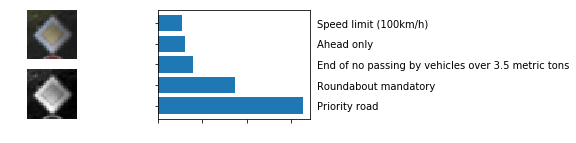

In [88]:
plot_image_statistics(predictions, np.random.randint(low=0,high=len(X_test_processed)))

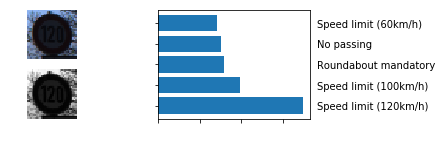

In [89]:
plot_image_statistics(predictions, np.random.randint(low=0,high=len(X_test_processed)))

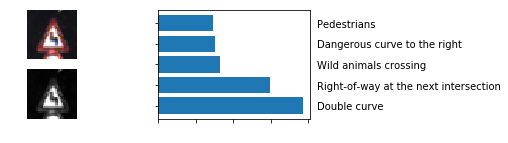

In [90]:
plot_image_statistics(predictions, np.random.randint(low=0,high=len(X_test_processed)))

---
# Random images from the internet

### Load and Output the Images

In [91]:
web_img_dir = "web_examples/"

In [92]:
os.listdir(web_img_dir)

['1.jpg', '2.jpg', '6.jpg', '5.jpg', '4.jpg', '3.jpg']

In [93]:
original_image_names = os.listdir(web_img_dir)
original_image_names = list(map(lambda name: web_img_dir + name, 
                                original_image_names))
print(original_image_names)

['web_examples/1.jpg', 'web_examples/2.jpg', 'web_examples/6.jpg', 'web_examples/5.jpg', 'web_examples/4.jpg', 'web_examples/3.jpg']


In [94]:
import matplotlib.image as mpimg

In [95]:
original_images = list(map(lambda img: mpimg.imread(img), original_image_names))

In [96]:
def show_image_list(img_list, 
                    cols=3, 
                    fig_size=(15, 5), 
                    img_labels=original_image_names, 
                    show_ticks=True):
    
    """
    Convenience function used to show a list of images
    This function is borrowed from: 
    https://github.com/kenshiro-o/CarND-LaneLines-P1/blob/master/Lane_Detection_Term_1.ipynb
    """
    
    img_count = len(img_list)
    
    rows = np.ceil(img_count / cols)
    
    cmap = None
    
    plt.figure(figsize=fig_size)
    
    for i in range(0, img_count):
        
        img_name = img_labels[i]
        
        plt.subplot(rows, cols, i+1)
        
        img = img_list[i]
        
        if len(img.shape) < 3:
            cmap = "gray"
        
        if not show_ticks:
            plt.xticks([])
            plt.yticks([])
            
        plt.title(img_name)    
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()
    plt.show()

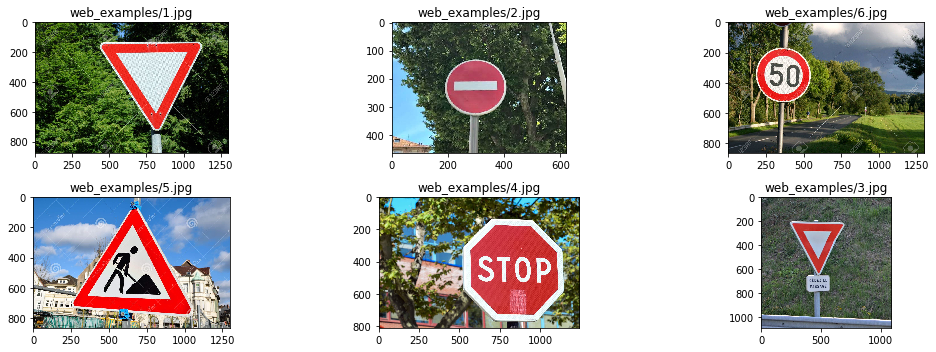

In [97]:
show_image_list(img_list=original_images)

All the images are different shapes from what our model pipeline expect. Let's reshape them and read them in as an array.  

In [98]:
from scipy.misc import imresize

In [99]:
web_x = np.array([np.array(imresize(arr=mpimg.imread(fname), size=[32,32,3])) for fname in original_image_names])

In [100]:
web_x.shape

(6, 32, 32, 3)

Let's see what they look like now

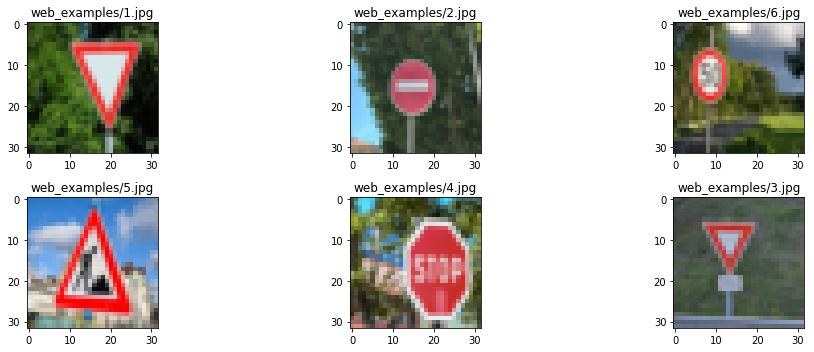

In [101]:
show_image_list(img_list=web_x)

In [102]:
web_x_preprocessed = preprocess(web_x)

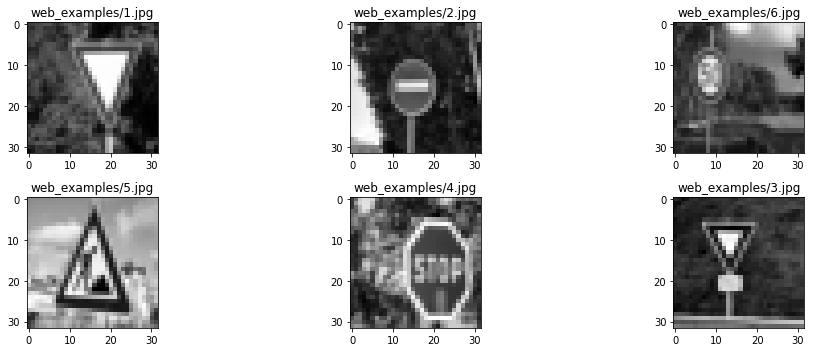

In [103]:
show_image_list(web_x_preprocessed.squeeze())

Be amazing if it recognizes any of these.  

### Predict the Sign Type for Each Image

In [104]:
# Provide labels of the captured images:
y_custom = np.array([
    13, # "web_examples/1.jpg"
    17, # "web_examples/2.jpg"
    2, # "web_examples/3.jpg"
    25, # "web_examples/4.jpg"
    14, # "web_examples/5.jpg"
    13, # "web_examples/6.jpg"
])

In [105]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_processed)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_processed[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid_processed, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    test_accuracy = evaluate(X_test_processed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    test_accuracy = evaluate(web_x_preprocessed, y_custom)
    print("Web Accuracy = {:.3f}".format(test_accuracy))

    top_k_predictions = tf.nn.top_k(logits, 5)
    
    predictions = sess.run(top_k_predictions, feed_dict={x: web_x_preprocessed, y: y_custom})

Training...

EPOCH 1 ...
Validation Accuracy = 0.184

EPOCH 2 ...
Validation Accuracy = 0.323

EPOCH 3 ...
Validation Accuracy = 0.423

EPOCH 4 ...
Validation Accuracy = 0.508

EPOCH 5 ...
Validation Accuracy = 0.583

EPOCH 6 ...
Validation Accuracy = 0.630

EPOCH 7 ...
Validation Accuracy = 0.656

EPOCH 8 ...
Validation Accuracy = 0.691

EPOCH 9 ...
Validation Accuracy = 0.709

EPOCH 10 ...
Validation Accuracy = 0.723

EPOCH 11 ...
Validation Accuracy = 0.744

EPOCH 12 ...
Validation Accuracy = 0.763

EPOCH 13 ...
Validation Accuracy = 0.759

EPOCH 14 ...
Validation Accuracy = 0.772

EPOCH 15 ...
Validation Accuracy = 0.790

EPOCH 16 ...
Validation Accuracy = 0.804

EPOCH 17 ...
Validation Accuracy = 0.791

EPOCH 18 ...
Validation Accuracy = 0.796

EPOCH 19 ...
Validation Accuracy = 0.806

EPOCH 20 ...
Validation Accuracy = 0.817

EPOCH 21 ...
Validation Accuracy = 0.812

EPOCH 22 ...
Validation Accuracy = 0.814

EPOCH 23 ...
Validation Accuracy = 0.816

EPOCH 24 ...
Validation Accura

### Analyze Performance

33% accuracy.  

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [106]:
import matplotlib.gridspec as gridspec

def plot_image_statistics(predictions, index):
    """
    Plots prediction statistics for a single example.

    Parameters
    ----------
    predictions   : 
                    Array of predictions.
    index         : 
                    Index of the example we need to plot statistics for
    """
        
    # Prepare the grid
    plt.figure(figsize = (6, 2))
    gridspec.GridSpec(2, 2)
    
    # Plot original image
    plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
    plt.imshow(web_x[index])
    plt.axis('off')

    # Plot preprocessed image
    plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
    plt.imshow(web_x_preprocessed[index].squeeze(), cmap='gray')
    plt.axis('off')

    # Plot predictions
    plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
    plt.barh(np.arange(5)+.5, predictions[0][index], align='center')
    
    label_index = predictions[1][index].astype(int)
    
    y_ticks = []

    for i in label_index: 
        stupid = signnames.at[signnames.index[i],'SignName']
        y_ticks.append(stupid)
    
    plt.yticks(np.arange(5)+.5,y_ticks)
    plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    
    plt.show()

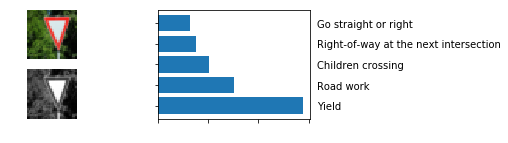

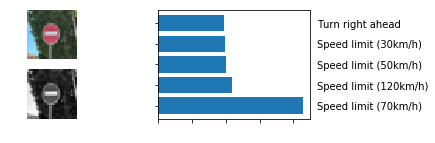

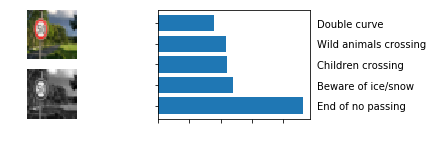

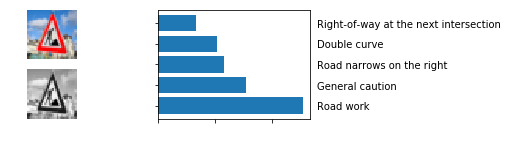

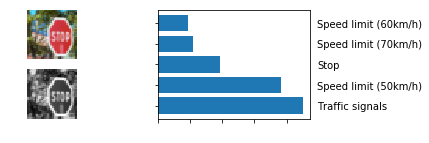

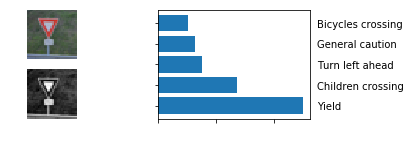

In [107]:
for i in range(0, len(web_x_preprocessed)): 
    plot_image_statistics(predictions, i)

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [109]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")